In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imputed/all_data_airpol_geo_payer_race.csv
/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv
/kaggle/input/widsdatathon2024-challenge1/training.csv
/kaggle/input/widsdatathon2024-challenge1/test.csv


In [2]:
pd.set_option('display.max_rows', 83)

In [3]:
train = pd.read_csv('/kaggle/input/widsdatathon2024-challenge1/training.csv')
test = pd.read_csv('/kaggle/input/widsdatathon2024-challenge1/test.csv')
imputed = pd.read_csv('/kaggle/input/imputed/all_data_airpol_geo_payer_race.csv')

In [4]:
test.shape

(5792, 82)

In [5]:
train.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'in

In [6]:
raw_all = pd.concat([train.drop(columns='DiagPeriodL90D'), test], axis=0).reset_index()

In [7]:
imputed.columns

Index(['Unnamed: 0', 'index', 'patient_id', 'patient_state', 'patient_zip3',
       'patient_age', 'patient_gender', 'breast_cancer_diagnosis_code',
       'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code',
       'Region', 'Division', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s',
       'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female',
       'married', 'divorced', 'never_married', 'widowed', 'family_size',
       'family_dual_income', 'income_household_median',
       'income_household_under_5', 'income_household_5_to_10',
       'income_household_10_to_15', 'income_household_15_to_20',
       'income_household_20_to_25', 'income_household_25_to_35',
       'income_household_35_to_50', 'income_household_50_to_75',
       'income_household_75_to_100', 'income_household_100_to_150',
       'income_household_150_over', 'income_household_six_figure',
       'income_individual_median', 'home_

In [8]:
imputed.tail()

,Unnamed: 0,index,patient_id,patient_state,patient_zip3,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,...,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,payer_type,patient_race
18693,18693,5787,977076,KY,404,63,F,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,...,20.813636,0.350000,30.152174,6.473913,5.908696,39.947326,7.622672,9.154618,COMMERCIAL,White
18694,18694,5788,922960,IA,507,69,F,C50912,Malignant neoplasm of unspecified site of left...,C773,...,15.900000,2.800000,16.800000,5.475000,6.875000,35.825340,7.610534,9.712786,MEDICAID,White
18695,18695,5789,759690,WA,980,84,F,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,...,6.432075,5.094340,31.275472,5.309434,5.807547,36.618644,4.939852,23.393650,MEDICARE ADVANTAGE,White
18696,18696,5790,911717,OK,740,58,F,1749,"Malignant neoplasm of breast (female), unspeci...",C773,...,16.603030,0.513636,25.877273,14.926866,7.600000,39.832235,8.030925,9.769358,COMMERCIAL,White
18697,18697,5791,327597,NY,114,83,F,C50111,Malignant neoplasm of central portion of right...,C773,...,12.613043,9.122727,47.270833,7.154167,2.558333,37.963594,6.844970,29.428387,MEDICARE ADVANTAGE,Hispanic


In [9]:
imputed.drop(columns=['Unnamed: 0', 'patient_gender'], inplace=True)

#Let's impute BMI values with XGBRegressor

In [10]:
imputed['bmi'] = raw_all['bmi']


In [11]:
im_types = imputed.dtypes.to_dict()
for key in im_types:
    if im_types[key]=='O':
        imputed[key] = imputed[key].astype('category')
imputed['patient_zip3']=imputed['patient_zip3'].astype('category')
imputed.dtypes

index                                  int64
patient_id                             int64
patient_state                       category
patient_zip3                        category
patient_age                            int64
breast_cancer_diagnosis_code        category
breast_cancer_diagnosis_desc        category
metastatic_cancer_diagnosis_code    category
Region                              category
Division                            category
population                           float64
density                              float64
age_median                           float64
age_under_10                         float64
age_10_to_19                         float64
age_20s                              float64
age_30s                              float64
age_40s                              float64
age_50s                              float64
age_60s                              float64
age_70s                              float64
age_over_80                          float64
male      

In [12]:
miss_bmi = raw_all['bmi'].isna()
train_bmi = imputed[~miss_bmi]
impute_bmi = imputed[miss_bmi]

In [13]:
print(f'training on: {len(train_bmi)} \n number of datapoints to impute: {len(impute_bmi)}')

training on: 5718 
 number of datapoints to impute: 12980


In [14]:
train_bmi.dtypes

index                                  int64
patient_id                             int64
patient_state                       category
patient_zip3                        category
patient_age                            int64
breast_cancer_diagnosis_code        category
breast_cancer_diagnosis_desc        category
metastatic_cancer_diagnosis_code    category
Region                              category
Division                            category
population                           float64
density                              float64
age_median                           float64
age_under_10                         float64
age_10_to_19                         float64
age_20s                              float64
age_30s                              float64
age_40s                              float64
age_50s                              float64
age_60s                              float64
age_70s                              float64
age_over_80                          float64
male      

In [15]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score


In [16]:
X= train_bmi.drop(columns=['index', 'patient_id', 'bmi'])
y = train_bmi['bmi']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=66)

In [18]:
gbm = xgb.XGBRegressor(enable_categorical = True)
reg_cv = GridSearchCV(gbm, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
                            ,'max_depth': [3,4,6], 'n_estimators': [500,1000]}, verbose=3)
reg_cv.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END colsample_bytree=1.0, max_depth=3, min_child_weight=1.0, n_estimators=500;, score=-0.624 total time=   3.1s
[CV 2/5] END colsample_bytree=1.0, max_depth=3, min_child_weight=1.0, n_estimators=500;, score=-0.545 total time=   2.3s
[CV 3/5] END colsample_bytree=1.0, max_depth=3, min_child_weight=1.0, n_estimators=500;, score=-0.508 total time=   2.1s
[CV 4/5] END colsample_bytree=1.0, max_depth=3, min_child_weight=1.0, n_estimators=500;, score=-0.390 total time=   2.1s
[CV 5/5] END colsample_bytree=1.0, max_depth=3, min_child_weight=1.0, n_estimators=500;, score=-0.328 total time=   2.1s
[CV 1/5] END colsample_bytree=1.0, max_depth=3, min_child_weight=1.0, n_estimators=1000;, score=-0.717 total time=   3.5s
[CV 2/5] END colsample_bytree=1.0, max_depth=3, min_child_weight=1.0, n_estimators=1000;, score=-0.619 total time=   5.3s
[CV 3/5] END colsample_bytree=1.0, max_depth=3, min_child_weight=1.0, n_estimators=1000;, 

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [1.0], 'max_depth': [3, 4, 6],
                         'min_child_weight': [1.0, 1.2],
                         'n_estimators': [500, 1000]},
             verbose=3)

In [19]:
gbm_bmi_pred = xgb.XGBRegressor(**reg_cv.best_params_, enable_categorical =  True)
gbm_bmi_pred.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
predictions = gbm_bmi_pred.predict(X_test)
gbm_bmi_pred.score(X_test,y_test)

-0.29471351572589954

In [21]:
bmi_pred = gbm_bmi_pred.predict(impute_bmi.drop(columns=['index', 'patient_id', 'bmi']))

In [22]:
missing_bmi_index = raw_all[raw_all['bmi'].isna()].index.tolist()
print(missing_bmi_index[0:10])

[0, 3, 4, 5, 7, 8, 9, 10, 11, 12]


In [23]:
raw_all.head(10)

,index,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,...,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
0,0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,...,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528
1,1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,...,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179
2,2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,...,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351
3,3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,...,16.716667,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123
4,4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,...,13.334000,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197
5,5,111545,White,MEDICARE ADVANTAGE,NY,141,66,F,NaN,1749,...,2.465714,13.717143,8.888235,0.638235,25.000000,4.797143,7.745714,40.107248,6.181812,13.562528
6,6,914071,NaN,COMMERCIAL,CA,900,51,F,29.05,C50912,...,45.526154,11.901538,20.760000,14.737500,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261
7,7,479368,White,COMMERCIAL,IL,619,60,F,NaN,C50512,...,2.723333,15.260000,10.890000,0.503333,24.275862,8.753333,7.506667,37.646770,7.295977,12.914805
8,8,994014,White,MEDICARE ADVANTAGE,NaN,973,82,F,NaN,1744,...,10.621538,19.371875,14.593651,1.620968,26.015254,6.645313,10.955385,36.323573,4.744352,10.439314
9,9,155485,NaN,COMMERCIAL,IL,617,64,F,NaN,C50912,...,3.041509,11.816981,8.443396,0.190566,23.843396,4.684906,9.016981,37.773830,7.299998,14.942968


In [24]:
for count, idx in enumerate(missing_bmi_index):
    imputed.loc[idx, 'bmi'] = bmi_pred[count]

In [25]:
imputed.head(10)

,index,patient_id,patient_state,patient_zip3,patient_age,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,...,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,payer_type,patient_race,bmi
0,0,475714,CA,924,84,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,Pacific,...,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,MEDICAID,White,27.240685
1,1,349367,CA,928,62,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,Pacific,...,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,COMMERCIAL,White,28.490000
2,2,138632,TX,760,43,C50112,Malignant neoplasm of central portion of left ...,C773,South,West South Central,...,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,COMMERCIAL,White,38.090000
3,3,617843,CA,926,45,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,Pacific,...,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,COMMERCIAL,White,23.721220
4,4,817482,ID,836,55,1749,"Malignant neoplasm of breast (female), unspeci...",C773,West,Mountain,...,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,COMMERCIAL,White,28.242081
5,5,111545,NY,141,66,1749,"Malignant neoplasm of breast (female), unspeci...",C7981,Northeast,Middle Atlantic,...,0.638235,25.000000,4.797143,7.745714,40.107248,6.181812,13.562528,MEDICARE ADVANTAGE,White,32.387657
6,6,914071,CA,900,51,C50912,Malignant neoplasm of unspecified site of left...,C779,West,Pacific,...,14.737500,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261,COMMERCIAL,Hispanic,29.050000
7,7,479368,IL,619,60,C50512,Malig neoplasm of lower-outer quadrant of left...,C773,Midwest,East North Central,...,0.503333,24.275862,8.753333,7.506667,37.646770,7.295977,12.914805,COMMERCIAL,White,26.860521
8,8,994014,OR,973,82,1744,Malignant neoplasm of upper-outer quadrant of ...,C7800,West,Pacific,...,1.620968,26.015254,6.645313,10.955385,36.323573,4.744352,10.439314,MEDICARE ADVANTAGE,White,22.516697
9,9,155485,IL,617,64,C50912,Malignant neoplasm of unspecified site of left...,C773,Midwest,East North Central,...,0.190566,23.843396,4.684906,9.016981,37.773830,7.299998,14.942968,COMMERCIAL,White,33.895370


In [26]:
imputed.to_csv('bmi_imputed.csv', index=False)

In [27]:
imputed.isna().sum()

index                               0
patient_id                          0
patient_state                       0
patient_zip3                        0
patient_age                         0
breast_cancer_diagnosis_code        0
breast_cancer_diagnosis_desc        0
metastatic_cancer_diagnosis_code    0
Region                              0
Division                            0
population                          1
density                             1
age_median                          1
age_under_10                        1
age_10_to_19                        1
age_20s                             1
age_30s                             1
age_40s                             1
age_50s                             1
age_60s                             1
age_70s                             1
age_over_80                         1
male                                1
female                              1
married                             1
divorced                            1
never_marrie

In [28]:
imputed.fillna(imputed.select_dtypes(np.number).mean(), inplace=True)

In [29]:
imputed.isna().sum()

index                               0
patient_id                          0
patient_state                       0
patient_zip3                        0
patient_age                         0
breast_cancer_diagnosis_code        0
breast_cancer_diagnosis_desc        0
metastatic_cancer_diagnosis_code    0
Region                              0
Division                            0
population                          0
density                             0
age_median                          0
age_under_10                        0
age_10_to_19                        0
age_20s                             0
age_30s                             0
age_40s                             0
age_50s                             0
age_60s                             0
age_70s                             0
age_over_80                         0
male                                0
female                              0
married                             0
divorced                            0
never_marrie

In [30]:
imputed.to_csv('no_nans.csv', index=False)

# Let's check the results of missing value handling on the results 

In [31]:
fe_engineerd = imputed.copy(deep=True)

New features

In [32]:
fe_engineerd['underweight']= np.where(fe_engineerd['bmi']<18.5, 1, 0) 
fe_engineerd['obese'] = np.where(fe_engineerd['bmi']>30, 1, 0) 
fe_engineerd['young_ind'] = np.where(fe_engineerd['patient_age']<40, 1, 0) 

fe_engineerd['desolated'] =  fe_engineerd['commute_time']/fe_engineerd['density']
fe_engineerd['home_wealth'] = (fe_engineerd['home_value']*fe_engineerd['home_ownership'])/1000000
fe_engineerd['air_quality'] = fe_engineerd['Ozone'] + fe_engineerd['PM25'] + fe_engineerd['N02']
fe_engineerd['wealth_index'] = (fe_engineerd['unemployment_rate'] * fe_engineerd['poverty'] * fe_engineerd['health_uninsured'] * fe_engineerd['limited_english']) /1000
fe_engineerd['education_ratio'] = fe_engineerd['education_less_highschool'] / fe_engineerd['education_college_or_above']
fe_engineerd['hh_income_ratio'] = (fe_engineerd['income_household_under_5'] + fe_engineerd['income_household_5_to_10'] )/fe_engineerd['income_household_six_figure']
 
fe_engineerd['race_ration'] = (fe_engineerd['race_black'] + fe_engineerd['race_asian'] + fe_engineerd['race_native'] + fe_engineerd['race_pacific']+ fe_engineerd['race_other']+ fe_engineerd['race_multiple']+ fe_engineerd['hispanic'])/fe_engineerd['race_white']

In [33]:
fe_engineerd['age_ratio'] = (fe_engineerd['age_under_10'] + fe_engineerd['age_10_to_19']) / (fe_engineerd['age_70s'] + fe_engineerd['age_over_80']+1)

In [34]:
fe_engineerd['age_ratio'].describe()

count    18698.000000
mean         2.034828
std          0.770858
min          0.543682
25%          1.611613
50%          2.003077
75%          2.382657
max         35.300000
Name: age_ratio, dtype: float64

In [35]:
fe_engineerd.head()

,index,patient_id,patient_state,patient_zip3,patient_age,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,...,obese,young_ind,desolated,home_wealth,air_quality,wealth_index,education_ratio,hh_income_ratio,race_ration,age_ratio
0,0,475714,CA,924,84,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,Pacific,...,0,0,0.023382,11.798909,79.494293,21.602549,2.863469,0.373972,2.779721,4.444668
1,1,349367,CA,928,62,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,Pacific,...,0,0,0.013331,41.653200,70.901475,2.917221,0.395453,0.078278,1.553169,2.413623
2,2,138632,TX,760,43,C50112,Malignant neoplasm of central portion of left ...,C773,South,West South Central,...,1,0,0.050133,17.292436,62.590311,2.228523,0.362889,0.095774,0.574321,2.649374
3,3,617843,CA,926,45,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,Pacific,...,0,0,0.014535,59.960170,65.193591,1.063895,0.104685,0.082758,0.795576,1.588927
4,4,817482,ID,836,55,1749,"Malignant neoplasm of breast (female), unspeci...",C773,West,Mountain,...,0,0,0.223895,19.262605,57.189004,1.124218,0.588750,0.204895,0.307016,1.780586


In [36]:
fe_engineerd.to_csv('clean_engineerd.csv', index = False)

In [37]:
fe_engineerd.tail()

,index,patient_id,patient_state,patient_zip3,patient_age,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,...,obese,young_ind,desolated,home_wealth,air_quality,wealth_index,education_ratio,hh_income_ratio,race_ration,age_ratio
18693,5787,977076,KY,404,63,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,South,East South Central,...,0,0,0.230099,9.434093,56.724616,0.318029,1.091824,0.631789,0.060195,2.069293
18694,5788,922960,IA,507,69,C50912,Malignant neoplasm of unspecified site of left...,C773,Midwest,West North Central,...,0,0,0.048520,7.400027,53.148660,1.627011,0.641232,0.390855,0.411296,2.080412
18695,5789,759690,WA,980,84,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,Pacific,...,0,0,0.028645,46.916172,64.952146,0.708046,0.117415,0.050002,0.694758,2.443050
18696,5790,911717,OK,740,58,1749,"Malignant neoplasm of breast (female), unspeci...",C773,South,West South Central,...,0,0,0.171824,9.595097,57.632519,0.615067,0.547102,0.336769,0.401146,2.223422
18697,5791,327597,NY,114,83,C50111,Malignant neoplasm of central portion of right...,C773,Northeast,Middle Atlantic,...,0,0,0.005456,33.219719,74.236951,8.729315,0.531548,0.105240,5.124766,2.222689


In [38]:
train_df = fe_engineerd.copy(deep=True)

In [39]:
train_clean = fe_engineerd[:12906]
test_clean = fe_engineerd[12906:]

In [40]:
print(train_clean.shape, test_clean.shape)

(12906, 91) (5792, 91)


In [41]:
train_clean['DiagPeriodL90D'] = train['DiagPeriodL90D']

/tmp/ipykernel_33/2621560646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean['DiagPeriodL90D'] = train['DiagPeriodL90D']


In [42]:
train_clean.head()

,index,patient_id,patient_state,patient_zip3,patient_age,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,...,young_ind,desolated,home_wealth,air_quality,wealth_index,education_ratio,hh_income_ratio,race_ration,age_ratio,DiagPeriodL90D
0,0,475714,CA,924,84,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,Pacific,...,0,0.023382,11.798909,79.494293,21.602549,2.863469,0.373972,2.779721,4.444668,1
1,1,349367,CA,928,62,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,Pacific,...,0,0.013331,41.653200,70.901475,2.917221,0.395453,0.078278,1.553169,2.413623,1
2,2,138632,TX,760,43,C50112,Malignant neoplasm of central portion of left ...,C773,South,West South Central,...,0,0.050133,17.292436,62.590311,2.228523,0.362889,0.095774,0.574321,2.649374,1
3,3,617843,CA,926,45,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,Pacific,...,0,0.014535,59.960170,65.193591,1.063895,0.104685,0.082758,0.795576,1.588927,0
4,4,817482,ID,836,55,1749,"Malignant neoplasm of breast (female), unspeci...",C773,West,Mountain,...,0,0.223895,19.262605,57.189004,1.124218,0.588750,0.204895,0.307016,1.780586,0


In [43]:
train_clean.to_csv('new_train.csv', index= False)
test_clean.to_csv('new_test.csv', index= False)

In [44]:
train_clean['DiagPeriodL90D']=train_clean['DiagPeriodL90D'].astype('category')

/tmp/ipykernel_33/3469829233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean['DiagPeriodL90D']=train_clean['DiagPeriodL90D'].astype('category')


In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
le = LabelEncoder()

X = train_clean.drop(columns=[ 'index', 'patient_id', 'male', 'DiagPeriodL90D' ])
y = le.fit_transform(train_clean['DiagPeriodL90D'])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=66)

In [48]:
num_col = [ 'patient_age', 'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80',  'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size', 'family_dual_income', 'income_household_median', 'income_household_under_5', 'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20', 'income_household_20_to_25', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_75_to_100', 'income_household_100_to_150', 'income_household_150_over', 'income_household_six_figure', 'income_individual_median', 'home_ownership', 'housing_units', 'home_value', 'rent_median', 'rent_burden', 'education_less_highschool', 'education_highschool', 'education_some_college', 'education_bachelors', 'education_graduate', 'education_college_or_above', 'education_stem_degree', 'labor_force_participation', 'unemployment_rate', 'self_employed', 'farmer', 'race_white', 'race_black', 'race_asian', 'race_native', 'race_pacific', 'race_other', 'race_multiple', 'hispanic', 'disabled', 'poverty', 'limited_english', 'commute_time', 'health_uninsured', 'veteran', 'Ozone', 'PM25', 'N02', 'bmi', 'underweight', 'obese', 'young_ind', 'desolated', 'home_wealth', 'air_quality', 'wealth_index', 'education_ratio', 'hh_income_ratio', 'age_ratio', 'race_ration']

In [49]:
train_clean.describe()

,index,patient_id,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,...,obese,young_ind,desolated,home_wealth,air_quality,wealth_index,education_ratio,hh_income_ratio,race_ration,age_ratio
count,12906.000000,12906.000000,12906.000000,12906.000000,12906.000000,12906.000000,12906.000000,12906.000000,12906.000000,12906.000000,...,12906.000000,12906.000000,12906.000000,12906.000000,12906.000000,12906.000000,12906.000000,12906.000000,12906.000000,12906.000000
mean,6452.500000,547381.196033,59.183326,20744.429774,1581.948703,40.502260,11.122784,12.945264,13.290374,12.862035,...,0.363319,0.066868,0.186284,20.703605,63.404329,4.925330,0.470023,0.222195,0.900741,2.039686
std,3725.785622,260404.959974,13.335216,13886.365763,2966.190381,4.036806,1.512318,1.923900,3.353973,2.324831,...,0.480974,0.249803,0.660848,13.206497,7.444322,11.635332,0.364180,0.189576,0.887456,0.785154
min,0.000000,100063.000000,18.000000,635.545455,0.916667,20.600000,0.000000,6.314286,5.925000,1.500000,...,0.000000,0.000000,0.001816,3.866071,41.541167,0.000000,0.000000,0.027822,0.019618,0.543682
25%,3226.250000,321517.000000,50.000000,9463.896552,171.857143,37.129825,10.160000,11.741176,11.013415,11.292105,...,0.000000,0.000000,0.015880,11.793675,57.402311,0.394173,0.243056,0.102518,0.258178,1.612680
50%,6452.500000,543522.000000,59.000000,19154.190480,700.337500,40.639344,11.039216,12.923944,12.538095,12.442647,...,0.000000,0.000000,0.040194,16.539690,62.813229,1.487039,0.373150,0.170398,0.687111,2.003077
75%,9678.750000,772671.750000,67.000000,30021.278690,1666.515385,42.934783,12.190000,14.019767,14.971053,14.026667,...,1.000000,0.000000,0.147539,26.066609,68.857711,4.222287,0.594257,0.267929,1.281477,2.382657
max,12905.000000,999896.000000,91.000000,71374.131580,21172.000000,54.570000,17.675000,35.300000,62.100000,25.471429,...,1.000000,1.000000,22.016529,91.985407,95.304224,137.794059,3.586777,2.346129,6.632274,35.300000


In [50]:
scaler = StandardScaler()


X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_test[num_col] = scaler.fit_transform(X_test[num_col])


In [51]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3, 4, 5],
        'learning_rate' : [0.001, 0.01, 0.02],
        'n_estimators' : [100, 500, 1000]
        }

In [52]:
xgb_new = xgb.XGBClassifier(objective='binary:logistic', enable_categorical=True)
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 66)
random_new = RandomizedSearchCV(xgb_new, param_distributions=params, n_iter=100, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=66 )
random_new.fit(X_train, y_train)
print(random_new.best_estimator_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=1000, subsample=0.6;, score=0.775 total time=  16.2s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=10, n_estimators=1000, subsample=0.6;, score=0.795 total time=  16.6s
[CV 1/3] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=4, min_child_weight=1, n_estimators=500, subsample=1.0;, score=0.775 total time=   6.2s
[CV 1/3] END colsample_bytree=0.6, gamma=1, learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8;, score=0.788 total time=   1.7s
[CV 2/3] END colsample_bytree=0.6, gamma=1, learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8;, score=0.805 total time=   1.8s
[CV 2/3] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=10, n_estimators=100, 

In [53]:
test_proba = random_new.predict_proba(X_test)
score_proba = roc_auc_score(y_test, test_proba[:, 1])
print(score_proba)

0.7808430968765189


In [54]:
best = random_new.best_estimator_
best_features = best.feature_importances_

In [55]:
import matplotlib.pyplot as plt

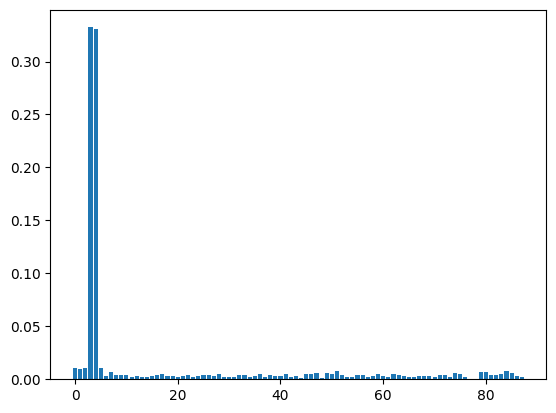

In [56]:
plt.bar(range(len(best_features)), best_features)
plt.show()

In [57]:
for idx, feat in enumerate(X.columns):
    print(feat, best_features[idx])

patient_state 0.011023191
patient_zip3 0.0094679445
patient_age 0.010764038
breast_cancer_diagnosis_code 0.33234137
breast_cancer_diagnosis_desc 0.33085135
metastatic_cancer_diagnosis_code 0.010472965
Region 0.0034634164
Division 0.006614687
population 0.0041463724
density 0.0039891796
age_median 0.0044840863
age_under_10 0.0025886144
age_10_to_19 0.0033082427
age_20s 0.002377021
age_30s 0.0016867843
age_40s 0.0026786414
age_50s 0.0042821616
age_60s 0.005017382
age_70s 0.0030698653
age_over_80 0.0028417595
female 0.0025704037
married 0.0034152744
divorced 0.0035848836
never_married 0.0022192043
widowed 0.003340536
family_size 0.0039690663
family_dual_income 0.0036852183
income_household_median 0.003395129
income_household_under_5 0.004835521
income_household_5_to_10 0.0019208044
income_household_10_to_15 0.0024954546
income_household_15_to_20 0.0020741904
income_household_20_to_25 0.0044028577
income_household_25_to_35 0.0036597827
income_household_35_to_50 0.0025135225
income_househol

In [58]:
test_clean.head()

,index,patient_id,patient_state,patient_zip3,patient_age,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,...,obese,young_ind,desolated,home_wealth,air_quality,wealth_index,education_ratio,hh_income_ratio,race_ration,age_ratio
12906,0,573710,IN,467,54,C50412,Malig neoplasm of upper-outer quadrant of left...,C773,Midwest,East North Central,...,1,0,0.291463,12.848207,57.829202,0.285810,0.692736,0.123927,0.092442,2.103073
12907,1,593679,FL,337,52,C50912,Malignant neoplasm of unspecified site of left...,C787,South,South Atlantic,...,0,0,0.015403,18.257627,58.357215,2.042298,0.240347,0.203070,0.409605,0.847931
12908,2,184532,CA,917,61,C50911,Malignant neoplasm of unsp site of right femal...,C773,West,Pacific,...,1,0,0.015880,35.156794,76.990275,6.033070,0.571530,0.090249,2.815961,2.177161
12909,3,447383,CA,917,64,C50912,Malignant neoplasm of unspecified site of left...,C779,West,Pacific,...,1,0,0.015880,35.156794,76.990275,6.033070,0.571530,0.090249,2.815961,2.177161
12910,4,687972,CA,900,40,C50412,Malig neoplasm of upper-outer quadrant of left...,C779,West,Pacific,...,0,0,0.005800,27.527409,73.998150,27.473246,0.609851,0.283686,2.398118,2.003077


In [59]:
test_clean.columns

Index(['index', 'patient_id', 'patient_state', 'patient_zip3', 'patient_age',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'Region', 'Division', 'population',
       'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s',
       'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80',
       'male', 'female', 'married', 'divorced', 'never_married', 'widowed',
       'family_size', 'family_dual_income', 'income_household_median',
       'income_household_under_5', 'income_household_5_to_10',
       'income_household_10_to_15', 'income_household_15_to_20',
       'income_household_20_to_25', 'income_household_25_to_35',
       'income_household_35_to_50', 'income_household_50_to_75',
       'income_household_75_to_100', 'income_household_100_to_150',
       'income_household_150_over', 'income_household_six_figure',
       'income_individual_median', 'home_ownership', 'housing_units',
       'ho

In [60]:

test_clean[num_col] = scaler.fit_transform(test_clean[num_col])

/tmp/ipykernel_33/191285285.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean[num_col] = scaler.fit_transform(test_clean[num_col])


In [61]:
sub_proba = random_new.predict_proba(test_clean.drop(columns=[ 'index', 'patient_id', 'male']))
test['DiagPeriodL90D'] = sub_proba[:, 1]
sub = test[['patient_id','DiagPeriodL90D']]
sub.head()

,patient_id,DiagPeriodL90D
0,573710,0.729023
1,593679,0.697628
2,184532,0.736956
3,447383,0.735022
4,687972,0.735448


In [62]:
sub.to_csv('submission.csv', index=False)

[CV 1/3] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=1000, subsample=0.6;, score=0.779 total time=  15.8s
[CV 2/3] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=1000, subsample=0.6;, score=0.798 total time=  19.1s
[CV 3/3] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.792 total time=   2.7s
[CV 1/3] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.001, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0;, score=0.775 total time=   1.2s
[CV 2/3] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.001, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0;, score=0.789 total time=   1.2s
[CV 3/3] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.001, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0;, score=0.782 total time=   1.2s
[CV 1/3] EN